In [1]:
import torch
from memflow.read_data.dataset_all import DatasetCombined
from memflow.pretrain_exist.pretrain_exist_binary import Classify_ExistJet
from memflow.unfolding_flow.utils import *

import numpy as np
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from math import floor

# from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
import vector

from utils import alter_variables

from earlystop import EarlyStopper
from memflow.unfolding_flow.utils import Compute_ParticlesTensor

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
from torch.profiler import profile, record_function, ProfilerActivity

from torcheval.metrics.functional import multiclass_f1_score

from random import randint
PI = torch.pi

In [31]:
path_to_dir = '/eos/user/a/adpetre/www/ttHbbAnalysis/MEMFlow/models_archive/classifier_exist_6/Transfer_Flow_transfer_flow_2nd_2nd_DiagNormal_NoTransf4_NoBins20_DNN:2_64/'
path_to_conf = path_to_dir + 'config_transfer_flow_2nd_2nd.yaml'
path_to_model = path_to_dir + 'model_transfer_flow_2nd_2nd.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read config file in 'conf'
with open(path_to_conf) as f:
    conf = OmegaConf.load(path_to_conf)

dtype = conf.training_params.dtype

if conf.training_params.dtype == "float32":
    dtype = torch.float32
elif conf.training_params.dtype == "float64":
    dtype = torch.float64
else:
    dtype = None

In [32]:
test_dataset = DatasetCombined(conf.input_dataset_test, dev=device, build=False,
                               dtype=dtype,
                                datasets=['partons_lab', 'reco_lab'],
                           reco_list_lab=['scaledLogReco_sortedBySpanet',
                                          'mask_scaledLogReco_sortedBySpanet',
                                          'mask_boost', 'scaledLogBoost'],
                           parton_list_lab=['logScaled_data_higgs_t_tbar_ISR'])

testLoader = DataLoader(
        test_dataset,
        batch_size= 4096
    )

>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Parton: Move tensors to device (cuda) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load scaledLogBoost
Load scaledLogReco_sortedBySpanet
Reco: Move tensors to device (cuda) memory
Loaded datasets:  ['partons_lab', 'reco_lab']


In [33]:
no_recoObjects = test_dataset.reco_lab.scaledLogReco_sortedBySpanet.shape[1]

# Initialize model
model = Classify_ExistJet(no_recoVars=5, # exist + 3-mom + position
            no_partonVars=4, # 3-mom + position
            no_recoObjects=no_recoObjects,

            no_transformers=conf.transformerConditioning.no_transformers,
            transformer_input_features=conf.transformerConditioning.input_features,
            transformer_nhead=conf.transformerConditioning.nhead,
            transformer_num_encoder_layers=conf.transformerConditioning.no_encoder_layers,
            transformer_num_decoder_layers=conf.transformerConditioning.no_decoder_layers,
            transformer_dim_feedforward=conf.transformerConditioning.dim_feedforward,
            transformer_activation=nn.GELU(),
             
            DNN_nodes=conf.DNN.nodes,
            DNN_layers=conf.DNN.layers,
            no_max_objects=conf.transferFlow.no_max_objects,
             
            device=device,
            dtype=dtype,
            eps=1e-4)


state_dict = torch.load(path_to_model, map_location="cpu")
model.load_state_dict(state_dict['model_state_dict']) 

if device == torch.device('cuda'):
    model = model.cuda()

model.eval()

Classify_ExistJet(
  (linearDNN_reco): Linear(in_features=5, out_features=128, bias=True)
  (linearDNN_parton): Linear(in_features=4, out_features=128, bias=True)
  (linearDNN_boost): Linear(in_features=4, out_features=128, bias=True)
  (gelu): GELU(approximate='none')
  (transformer_model): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0

In [57]:
# TODO: right now logScaled_reco_sortedBySpanet has null_token inside
def sample_existToken(model, logScaled_reco_sortedBySpanet, logScaled_partons, mask_reco, device, dtype, encode_position=True):
    null_token = torch.ones((logScaled_reco_sortedBySpanet.shape[0], 1, 5), device=device, dtype=dtype) * -1
    null_token[:,0,0] = 0 # exist flag = 0 not -1

    # mask for the null token = True
    null_token_mask = torch.ones((mask_reco.shape[0], 1), device=device, dtype=torch.bool)

    # attach null token and update the mask for the scaling_reco_lab
    scaling_reco_lab_withNullToken = torch.cat((null_token, logScaled_reco_sortedBySpanet), dim=1)
    mask_reco_withNullToken = torch.cat((null_token_mask, mask_reco), dim=1)
    
    scaledLogParton_afterLin = model.gelu(model.linearDNN_parton(logScaled_partons))
    scaledLogReco_afterLin = model.gelu(model.linearDNN_reco(scaling_reco_lab_withNullToken) * mask_reco_withNullToken[..., None])
        
    output_decoder = model.transformer_model(scaledLogParton_afterLin, scaledLogReco_afterLin, tgt_mask=model.tgt_mask)

    if encode_position:
        hot_encoded = [i for i in range(logScaled_reco_sortedBySpanet.shape[1] + 1)]
        hot_encoded = torch.tensor(hot_encoded, device=device, dtype=dtype).unsqueeze(dim=1)
        hot_encoded = hot_encoded.expand(output_decoder.shape[0], -1, -1)
        output_decoder = torch.cat((output_decoder, hot_encoded), dim=2)

    no_objects_per_event = torch.sum(mask_reco[:,:model.no_max_objects], dim=1) # compute the number of objects per event
    
    prob_each_jet = model.model(output_decoder).squeeze(dim=2)
    prob_each_jet = prob_each_jet[:,:model.no_max_objects]

    jetExist_sampled = torch.where(prob_each_jet < 0.5, 0, 1)

    return jetExist_sampled

def existQuality_print(sampledEvent, logScaled_reco_target, plotJets):
    # check exist flag
    target_exist = logScaled_reco_target[:,plotJets,0]
    sampled_exist = sampledEvent[:,plotJets]

    # check overlapping values
    mask_same_exist = target_exist == sampled_exist
    fraction_same_exist = (torch.count_nonzero(mask_same_exist)/torch.numel(mask_same_exist)).cpu().numpy()

    # keep only exist = 0
    mask_exist_0 = target_exist == 0
    mask_same_exist_0 = target_exist[mask_exist_0] == sampled_exist[mask_exist_0]
    fraction_same_exist_0 = (torch.count_nonzero(mask_same_exist_0)/torch.numel(mask_same_exist_0)).cpu().numpy()

    # keep only exist = 1
    mask_exist_1 = target_exist == 1
    mask_same_exist_1 = target_exist[mask_exist_1] == sampled_exist[mask_exist_1]
    fraction_same_exist_1 = (torch.count_nonzero(mask_same_exist_1)/torch.numel(mask_same_exist_1)).cpu().numpy()

    # plot quality of `exist` sampling
    fig, ax = plt.subplots(figsize=(3,2), dpi=100)
    ax.bar(["all Jets", "Jets With Exist=0", "Jets With Exist=1"],
           [fraction_same_exist, fraction_same_exist_0, fraction_same_exist_1],
           color ='maroon', width = 0.4)
    
    ax.set_title(f'jet = {plotJets}', fontsize=7)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_ylabel(f'correct assignments / total values ', fontsize=7)

def attach_position(input_tensor, position):
    position = position.expand(input_tensor.shape[0], -1, -1)
    input_tensor = torch.cat((input_tensor, position), dim=2)
    
    return input_tensor

no batches = 438
batch = 0
batch = 1


/tmp/adpetre/ipykernel_453419/965806651.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(3,2), dpi=100)


batch = 5
batch = 190


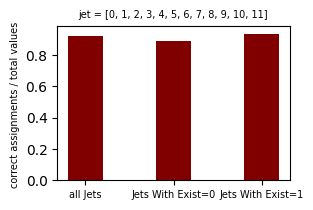

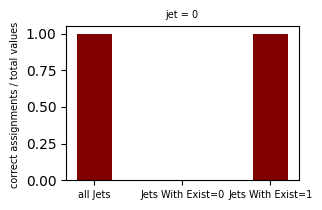

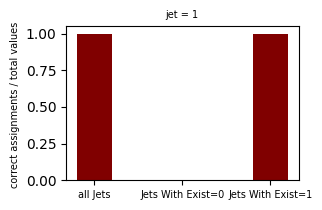

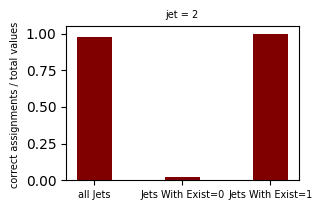

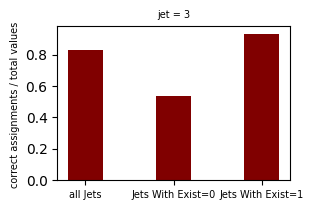

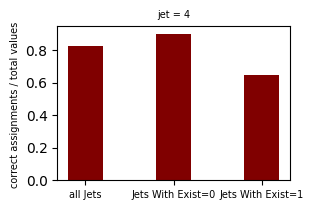

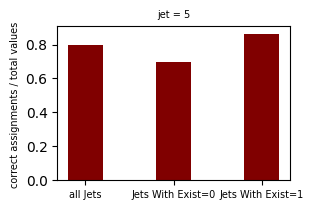

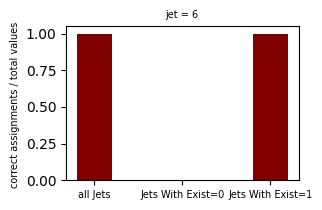

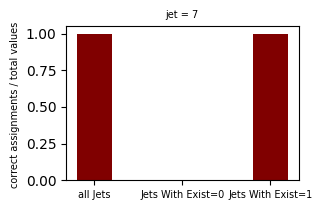

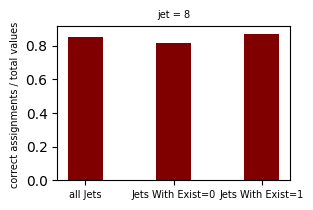

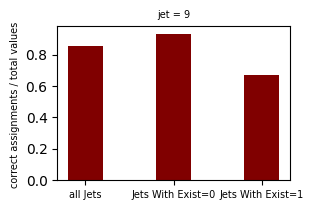

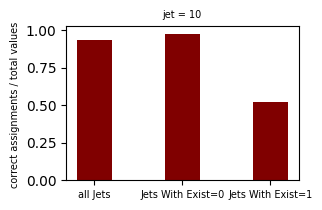

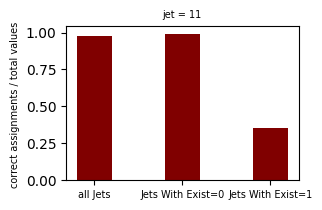

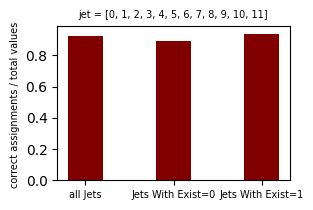

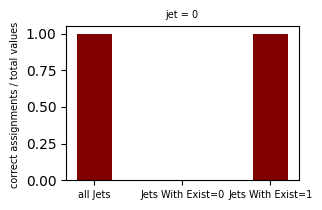

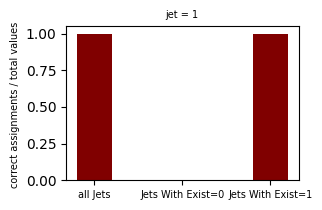

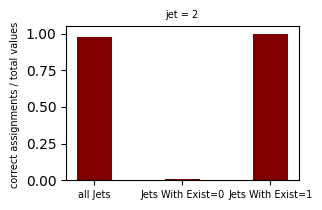

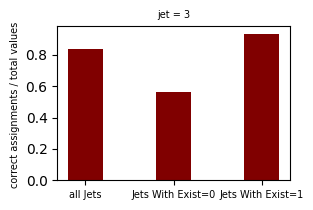

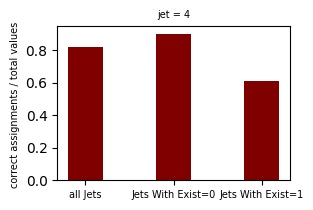

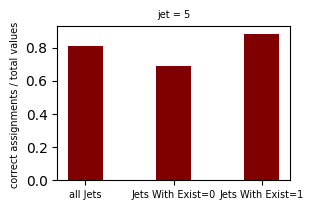

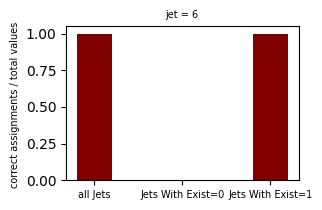

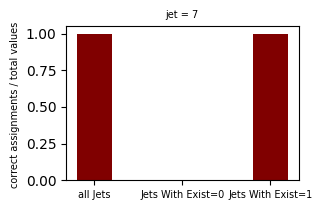

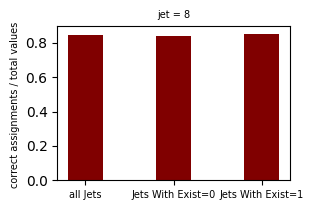

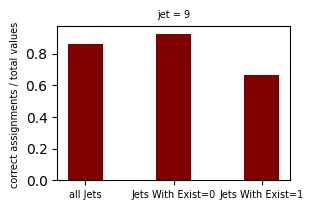

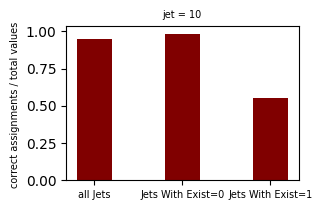

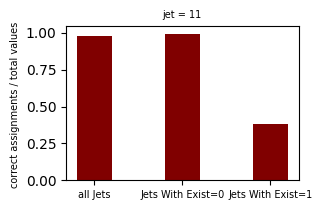

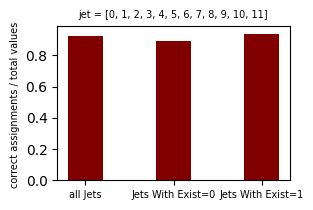

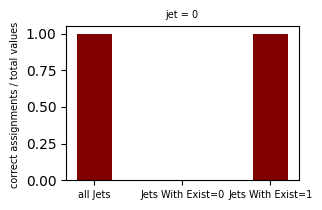

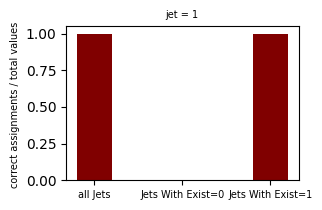

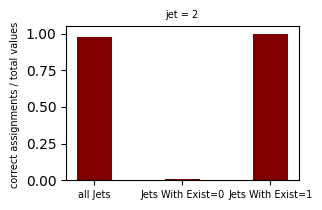

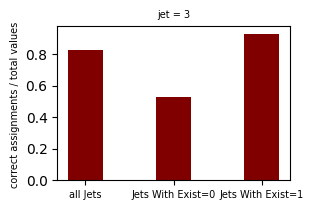

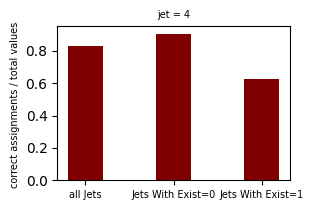

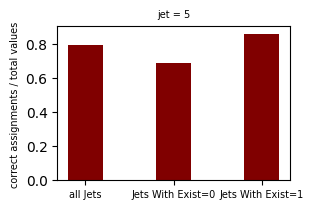

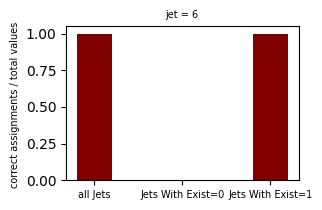

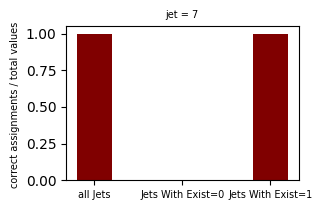

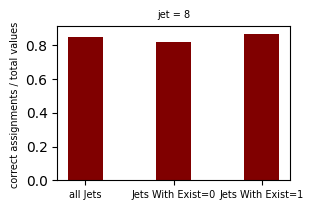

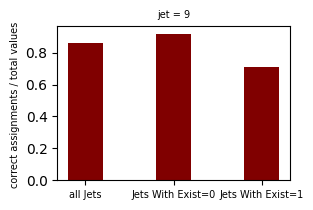

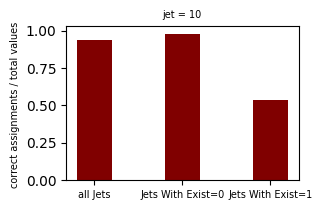

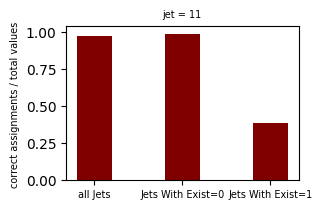

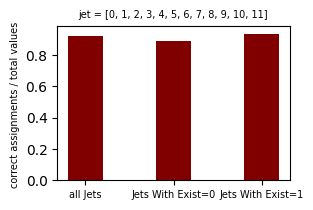

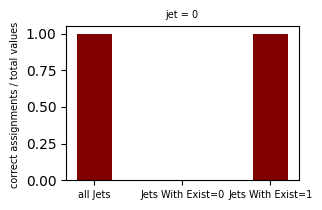

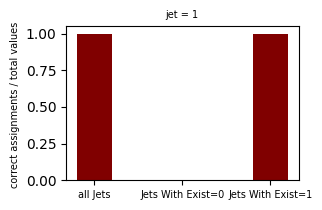

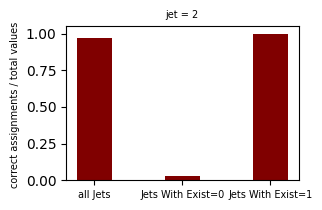

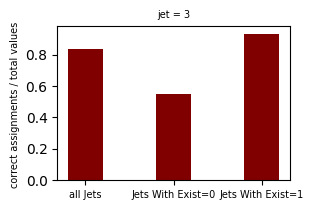

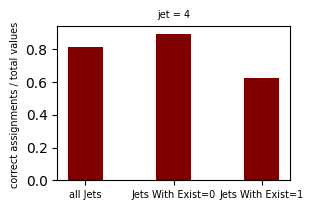

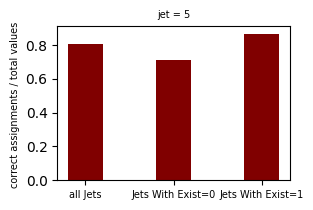

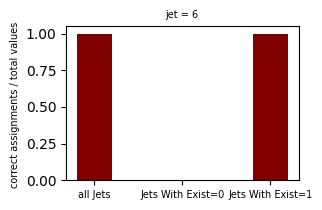

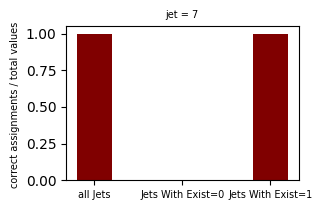

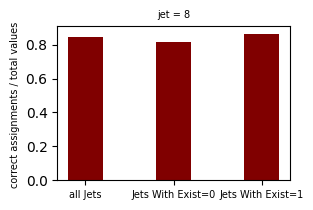

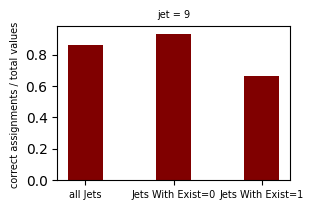

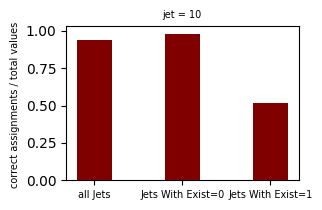

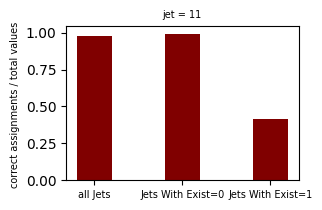

In [59]:
N_valid = 0

# attach one-hot encoded position for jets
pos_jets_lepton_MET = [pos for pos in range(8)] # 6 jets + lepton + MET
pos_other_jets = [8 for pos in range(no_recoObjects - 8)]

pos_jets_lepton_MET = torch.tensor(pos_jets_lepton_MET, device=device, dtype=dtype)
pos_other_jets = torch.tensor(pos_other_jets, device=device, dtype=dtype)
pos_logScaledReco = torch.cat((pos_jets_lepton_MET, pos_other_jets), dim=0).unsqueeze(dim=1)

# attach one-hot encoded position for partons
pos_partons = torch.tensor([0,1,2,3], device=device, dtype=dtype).unsqueeze(dim=1) # higgs, t1, t2, ISR

print(f'no batches = {len(testLoader)}')

check_batches = [0,1,5,190]

for i, data_batch in enumerate(testLoader):
    # Move data to device
    with torch.no_grad():

        (logScaled_partons,
        logScaled_reco_sortedBySpanet, mask_recoParticles,
        mask_boost, data_boost_reco) = data_batch
        
        # exist + 3-mom
        logScaled_reco_sortedBySpanet = logScaled_reco_sortedBySpanet[:,:,:4]

        # attach 1 hot-encoded position
        logScaled_reco_sortedBySpanet = attach_position(logScaled_reco_sortedBySpanet, pos_logScaledReco)
        logScaled_partons = attach_position(logScaled_partons, pos_partons)

        if i in check_batches:
            # print sampled partons
            print(f'batch = {i}')
            fullGeneratedEvent = sample_existToken(model, logScaled_reco_sortedBySpanet, logScaled_partons, mask_recoParticles, device, dtype)

            allJets = [i for i in range(conf.transferFlow.no_max_objects)]
            existQuality_print(fullGeneratedEvent, logScaled_reco_sortedBySpanet, allJets)

            for jet in range(conf.transferFlow.no_max_objects):
                existQuality_print(fullGeneratedEvent, logScaled_reco_sortedBySpanet, jet)
